In [1]:
from __future__ import print_function
from PIL import Image
from cv2 import *
import numpy as np
import os
import numpy.ma as ma
import shutil
from openpyxl import Workbook
import numpy.ma as ma
#import imutils
from itertools import *

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

from datetime import datetime
import os
import imaplib
import email
import time
import shutil
import csv
import cv2

import torch

In [2]:
os.getcwd()

'/Users/navya/Desktop/sds_capstone/src'

In [3]:
ls

IntraoperativeForm.JPG               image_segmentation_QI.ipynb
checkbox_extractor.py                image_segmentation_QI_rowwise.ipynb
drug_extraction.py                   image_segmentation_QI_save.ipynb
fetch_flowsheets.py                  main.py
graph_extraction.py                  test_checkbox_extraction.py


In [39]:
def alignImages(im1, im2, MAX_FEATURES, GOOD_MATCH_PERCENT):
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h

def image_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

def cropQI(img_name, labels=None):
    imFilename = img_name
    refFilename = "../src/IntraoperativeForm.JPG"
    imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)
    refFileWidth = imReference.shape[1]
   
    ref_width = imReference.shape[0]
    ref_height = imReference.shape[1]
    #plt.imshow(imReference)
    #plt.show()
    
    imPatientOrg = cv2.imread(imFilename, cv2.IMREAD_COLOR)
    og_width = imPatientOrg.shape[0]
    og_height = imPatientOrg.shape[1]
    #plt.imshow(imPatientOrg)
    #plt.show()
    
    patient = os.path.basename(imFilename)[:-4]
    imPatient = image_resize(imPatientOrg, width=refFileWidth)
    
    # Registered image will be restored in img.
    # img = aligned image (cv2)
    # im = aligned image (PIL)
    # The estimated homography will be stored in h.
    img, h = alignImages(imPatient, imReference, MAX_FEATURES=500, GOOD_MATCH_PERCENT=0.18)
    im = Image.fromarray(img)

    # determine chart pixel area (on standard form)
    standImg = cv2.imread(refFilename)
    standIm = Image.open(refFilename)
    edges = cv2.Canny(standImg, 50, 110)
    lines = cv2.HoughLinesP(image=edges, rho=1, theta=np.pi / 180, threshold=300, lines=np.array([]), minLineLength=1, maxLineGap=50)

    # determine chart edges -> based on location in IntraoperativeRecord.jpg (or standard form)
    minX = lines[0][0][0]
    minY = lines[0][0][1]
    maxX = lines[0][0][0]
    maxY = lines[0][0][1]

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if (x1 < minX):
            minX = x1
        if (x2 > maxX):
            maxX = x2
        if (y1 < minY):
            minY = y1
        if (y2 > maxY):
            maxY = y2

    Xdim = maxX - minX
    Ydim = maxY - minY
    edgeImg = img
    cv2.line(edgeImg, (minX, minY), (minX, maxY), (0, 0, 255), 2)
    cv2.line(edgeImg, (maxX, minY), (maxX, maxY), (0, 0, 255), 2)
    cv2.line(edgeImg, (minX, minY), (maxX, minY), (0, 0, 255), 2)
    cv2.line(edgeImg, (minX, maxY), (maxX, maxY), (0, 0, 255), 2)

    # Show Flowsheet Sections
    # SECTION 1
    XMin1 = minX + int((20 / 1190) * Xdim)
    XMax1 = minX + int((116 / 1190) * Xdim)
    YMin1 = minY + int((20 / 756) * Ydim)
    YMax1 = minY + int((310 / 756) * Ydim)

    # SECTION 2
    XMin2 = minX + int((120 / 1190) * Xdim)
    XMax2 = minX + int((1102 / 1190) * Xdim)
    YMin2 = minY + int((20 / 756) * Ydim)
    YMax2 = minY + int((310 / 756) * Ydim)

    # SECTION 3
    XMin3 = minX + int((1102 / 1190) * Xdim)
    XMax3 = minX + int((1190 / 1190) * Xdim)
    YMin3 = minY + int((20 / 756) * Ydim)
    YMax3 = minY + int((310 / 756) * Ydim)

    # SECTION 4
    XMin4 = minX + int((116 / 1190) * Xdim)
    XMax4 = minX + int((1102 / 1190) * Xdim)
    YMin4 = minY + int((310 / 756) * Ydim)
    YMax4 = minY + int((474 / 756) * Ydim)

    # SECTION 5
    XMin5 = minX + int((116 / 3000) * Xdim)
    XMax5 = minX + int((1102 / 2000) * Xdim)
    YMin5 = minY + int((460 / 756) * Ydim)
    YMax5 = minY + int((583 / 756) * Ydim)

    # SECTION 6
    XMin6 = minX + int((0 / 1190) * Xdim)
    XMax6 = minX + int((1190 / 1190) * Xdim)
    YMin6 = minY + int((587 / 756) * Ydim)
    YMax6 = minY + int((696 / 756) * Ydim)

    # SECTION 7
    XMin7 = minX + int((0 / 1190) * Xdim)
    XMax7 = minX + int((1190 / 1190) * Xdim)
    YMin7 = minY + int((701 / 756) * Ydim)
    YMax7 = minY + int((756 / 756) * Ydim)

    crop = np.array(im.crop((XMin5, YMin5, XMax5+1, YMax5+1)))
    plt.imshow(crop)
    plt.show()
    
    sections_coords = [XMin5, YMin5, XMax5+1, YMax5+1]
    
    '''# Section
    fig, ax = plt.subplots(1)
    plt.imshow(imPatient)
    xmin, ymin, xmax, ymax = sections_coords
    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    plt.show()'''
    
    # Option 1: Transform the blue box coordinates from the ref sheet size to the original sheet size
    if labels is None:
        pass
    else:
        fig, ax = plt.subplots(1)
        plt.imshow(imPatientOrg)
        plt.show()
        plt.axis('off')

        xmin, ymin, xmax, ymax = sections_coords
        w_prop = og_width/ref_width
        h_prop = og_height/ref_height

        xmin *= w_prop
        xmax *= w_prop
        ymin *= h_prop
        ymax *= h_prop
        
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                     edgecolor='b', facecolor='none')
        ax.add_patch(rect) 
        for box in labels:
                xmin, ymin, xmax, ymax = box.tolist()
                rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                         edgecolor='g', facecolor='none')
                ax.add_patch(rect)
           
        x_0, y_0, x_1, y_1 = 0, 0, imPatientOrg.shape[0], imPatientOrg.shape[1]
        image_coords = [x_0, y_0, x_1, y_1]
        #print(f"Image points: {image_coords}")
        
        sections_coords = [xmin, ymin, xmax, ymax]
        #print(f"Section points: {sections_coords}")
        
        section_w = xmax - xmin
        section_h = ymax - ymin
        x_0, y_0, x_1, y_1 = 0, 0, section_w, section_h
        new_bound = [x_0, y_0, x_1, y_1]
        #print(f"New image points: {new_bound}")
    return crop
        #cv2.imwrite(img_name[:-4]+'.jpg',crop)
        
#         cv2.imwrite(os.path.join("drive/MyDrive/Capstone_Project/Annotations/Rachel_Crop", img_name[:-4]+'.jpg'), crop)
#         cv2.waitKey(0)

def cropRow(img_name, labels=None):
    imFilename = img_name
    refFilename = "../src/IntraoperativeForm.JPG"
    imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)
    refFileWidth = imReference.shape[1]
   
    ref_width = imReference.shape[0]
    ref_height = imReference.shape[1]
    #plt.imshow(imReference)
    #plt.show()
    
    imPatientOrg = cv2.imread(imFilename, cv2.IMREAD_COLOR)
    og_width = imPatientOrg.shape[0]
    og_height = imPatientOrg.shape[1]
    #plt.imshow(imPatientOrg)
    #plt.show()
    
    patient = os.path.basename(imFilename)[:-4]
    imPatient = image_resize(imPatientOrg, width=refFileWidth)
    
    # Registered image will be restored in img.
    # img = aligned image (cv2)
    # im = aligned image (PIL)
    # The estimated homography will be stored in h.
    img, h = alignImages(imPatient, imReference, MAX_FEATURES=500, GOOD_MATCH_PERCENT=0.18)
    im = Image.fromarray(img)

    # determine chart pixel area (on standard form)
    standImg = cv2.imread(refFilename)
    standIm = Image.open(refFilename)
    edges = cv2.Canny(standImg, 50, 110)
    lines = cv2.HoughLinesP(image=edges, rho=1, theta=np.pi / 180, threshold=300, lines=np.array([]), minLineLength=1, maxLineGap=50)

    # determine chart edges -> based on location in IntraoperativeRecord.jpg (or standard form)
    minX = lines[0][0][0]
    minY = lines[0][0][1]
    maxX = lines[0][0][0]
    maxY = lines[0][0][1]

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if (x1 < minX):
            minX = x1
        if (x2 > maxX):
            maxX = x2
        if (y1 < minY):
            minY = y1
        if (y2 > maxY):
            maxY = y2

    Xdim = maxX - minX
    Ydim = maxY - minY
    edgeImg = img
    cv2.line(edgeImg, (minX, minY), (minX, maxY), (0, 0, 255), 2)
    cv2.line(edgeImg, (maxX, minY), (maxX, maxY), (0, 0, 255), 2)
    cv2.line(edgeImg, (minX, minY), (maxX, minY), (0, 0, 255), 2)
    cv2.line(edgeImg, (minX, maxY), (maxX, maxY), (0, 0, 255), 2)

    # Show Flowsheet Sections
    # SECTION 1
    XMin1 = minX + int((20 / 1190) * Xdim)
    XMax1 = minX + int((116 / 1190) * Xdim)
    YMin1 = minY + int((20 / 756) * Ydim)
    YMax1 = minY + int((310 / 756) * Ydim)

    # SECTION 2
    XMin2 = minX + int((120 / 1190) * Xdim)
    XMax2 = minX + int((1102 / 1190) * Xdim)
    YMin2 = minY + int((20 / 756) * Ydim)
    YMax2 = minY + int((310 / 756) * Ydim)

    # SECTION 3
    XMin3 = minX + int((1102 / 1190) * Xdim)
    XMax3 = minX + int((1190 / 1190) * Xdim)
    YMin3 = minY + int((20 / 756) * Ydim)
    YMax3 = minY + int((310 / 756) * Ydim)

    # SECTION 4
    XMin4 = minX + int((116 / 1190) * Xdim)
    XMax4 = minX + int((1102 / 1190) * Xdim)
    YMin4 = minY + int((310 / 756) * Ydim)
    YMax4 = minY + int((474 / 756) * Ydim)

    # SECTION 5
    XMin5 = minX + int((116 / 3000) * Xdim)
    XMax5 = minX + int((1102 / 2000) * Xdim)
    YMin5 = minY + int((460 / 756) * Ydim)
    YMax5 = minY + int((495 / 756) * Ydim)

    # SECTION 6
    XMin6 = minX + int((0 / 1190) * Xdim)
    XMax6 = minX + int((1190 / 1190) * Xdim)
    YMin6 = minY + int((587 / 756) * Ydim)
    YMax6 = minY + int((696 / 756) * Ydim)

    # SECTION 7
    XMin7 = minX + int((0 / 1190) * Xdim)
    XMax7 = minX + int((1190 / 1190) * Xdim)
    YMin7 = minY + int((701 / 756) * Ydim)
    YMax7 = minY + int((756 / 756) * Ydim)

    crop = np.array(im.crop((XMin5, YMin5, XMax5+1, YMax5+1)))
    plt.imshow(crop)
    plt.show()
    
    sections_coords = [XMin5, YMin5, XMax5+1, YMax5+1]
    
    '''# Section
    fig, ax = plt.subplots(1)
    plt.imshow(imPatient)
    xmin, ymin, xmax, ymax = sections_coords
    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                 edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    plt.show()'''
    
    # Option 1: Transform the blue box coordinates from the ref sheet size to the original sheet size
    if labels is None:
        pass
    else:
        fig, ax = plt.subplots(1)
        plt.imshow(imPatientOrg)
        plt.show()
        plt.axis('off')

        xmin, ymin, xmax, ymax = sections_coords
        w_prop = og_width/ref_width
        h_prop = og_height/ref_height

        xmin *= w_prop
        xmax *= w_prop
        ymin *= h_prop
        ymax *= h_prop
        
        rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                     edgecolor='b', facecolor='none')
        ax.add_patch(rect) 
        for box in labels:
                xmin, ymin, xmax, ymax = box.tolist()
                rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=1,
                                         edgecolor='g', facecolor='none')
                ax.add_patch(rect)
           
        x_0, y_0, x_1, y_1 = 0, 0, imPatientOrg.shape[0], imPatientOrg.shape[1]
        image_coords = [x_0, y_0, x_1, y_1]
        #print(f"Image points: {image_coords}")
        
        sections_coords = [xmin, ymin, xmax, ymax]
        #print(f"Section points: {sections_coords}")
        
        section_w = xmax - xmin
        section_h = ymax - ymin
        x_0, y_0, x_1, y_1 = 0, 0, section_w, section_h
        new_bound = [x_0, y_0, x_1, y_1]
        #print(f"New image points: {new_bound}")  
    return crop

In [42]:
ls ".."

2022-02-21.txt             labels_training_set_daisy/
Double crops/              models/
README.md                  old_models/
Rachel/                    quickstart.py
Rachel_New/                recoded_labels_crop/
annotations/               relabel_1/
compileLabels_riv.py       requirements.txt
cropped_images_relabel/    src/
cropped_labels/            templates/
frame_MasterList.csv       train_set_daisy/
images/                    training_set/
labelDistribution.py       triple_crops/
labels_training_set/


In [19]:
files_double = ["../Double crops/"+ x for x in os.listdir("../Double crops") if "jpg" in x]

In [20]:
files[0]

'../Rachel/189.jpg'

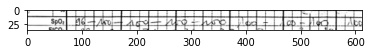

In [40]:
var = cropRow(files[5])

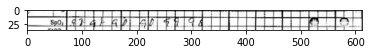

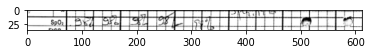

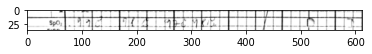

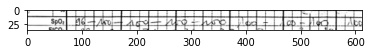

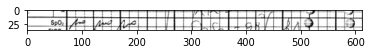

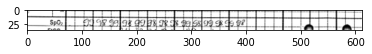

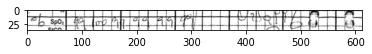

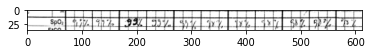

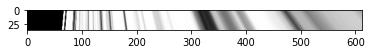

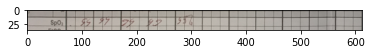

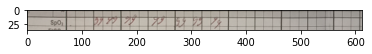

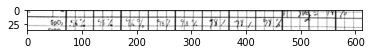

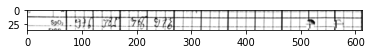

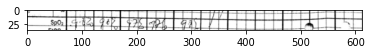

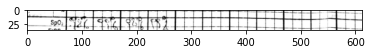

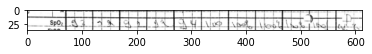

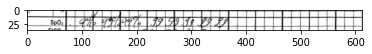

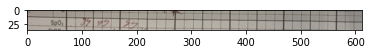

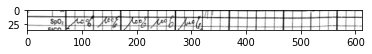

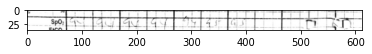

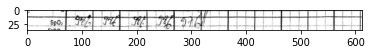

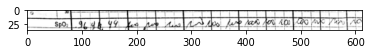

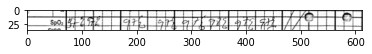

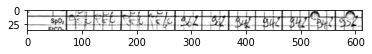

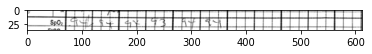

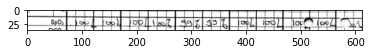

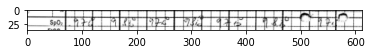

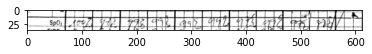

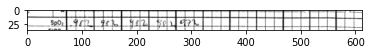

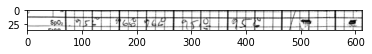

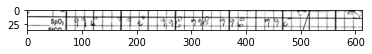

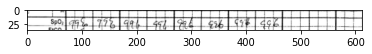

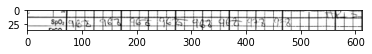

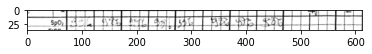

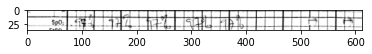

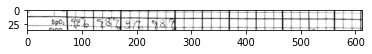

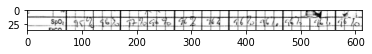

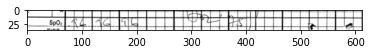

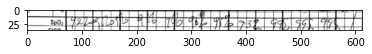

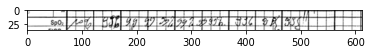

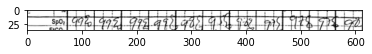

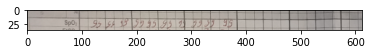

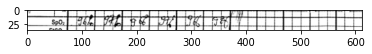

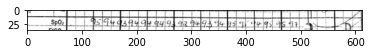

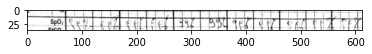

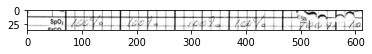

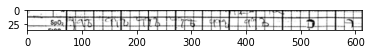

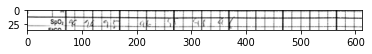

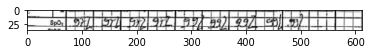

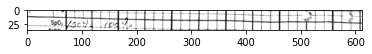

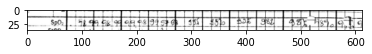

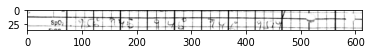

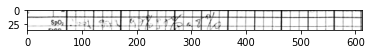

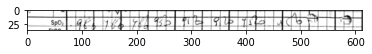

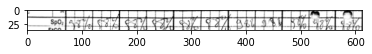

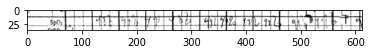

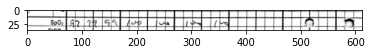

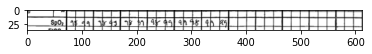

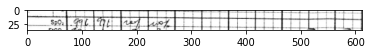

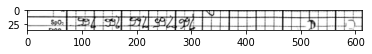

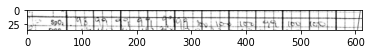

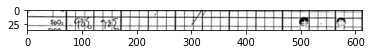

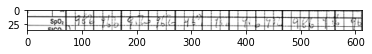

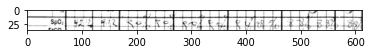

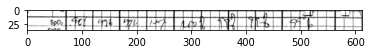

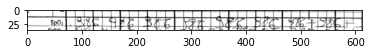

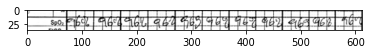

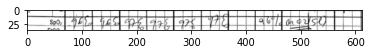

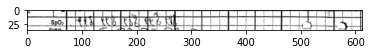

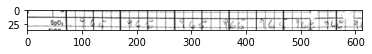

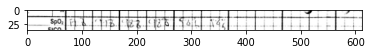

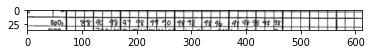

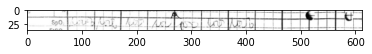

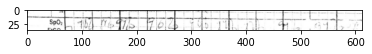

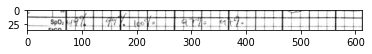

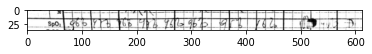

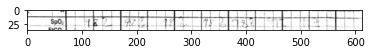

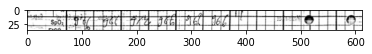

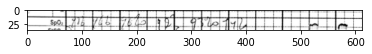

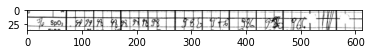

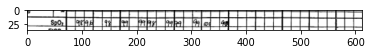

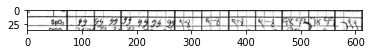

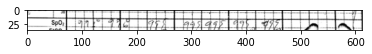

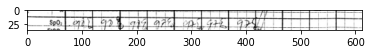

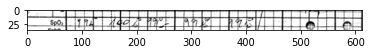

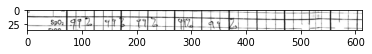

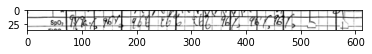

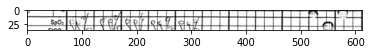

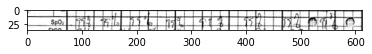

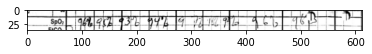

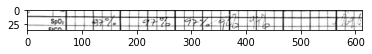

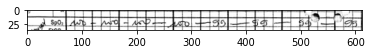

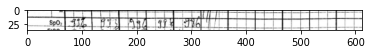

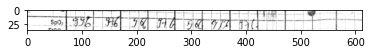

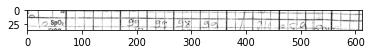

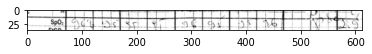

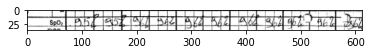

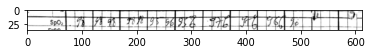

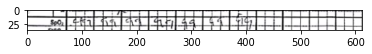

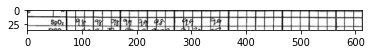

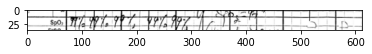

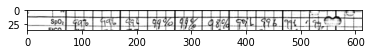

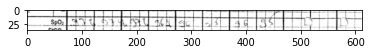

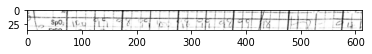

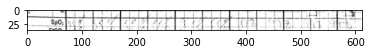

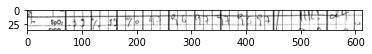

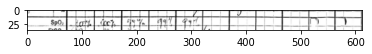

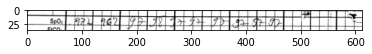

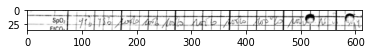

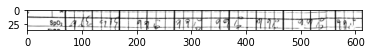

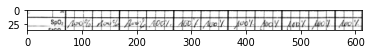

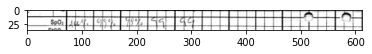

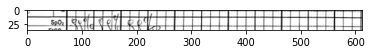

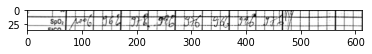

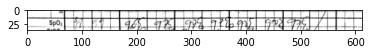

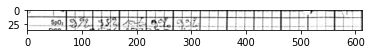

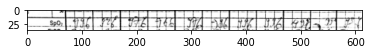

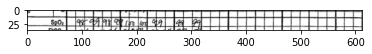

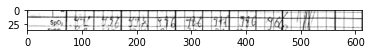

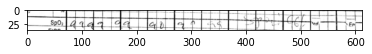

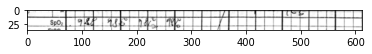

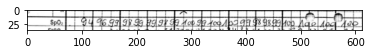

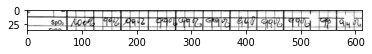

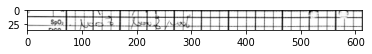

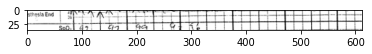

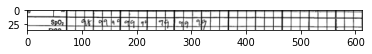

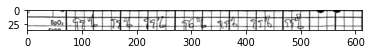

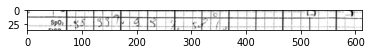

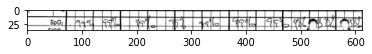

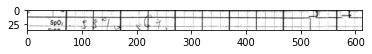

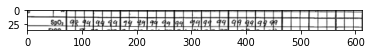

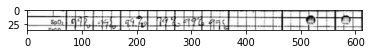

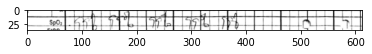

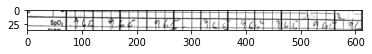

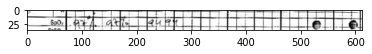

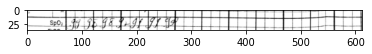

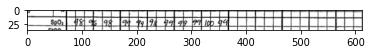

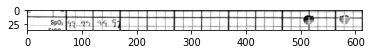

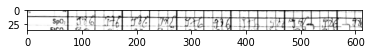

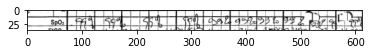

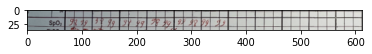

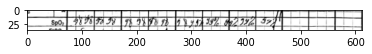

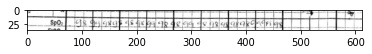

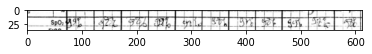

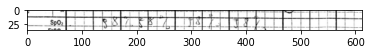

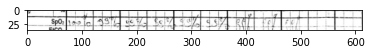

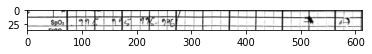

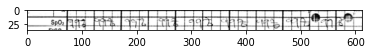

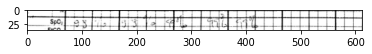

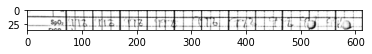

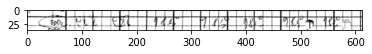

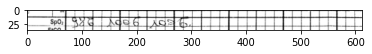

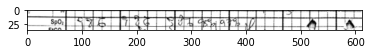

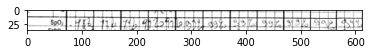

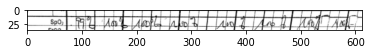

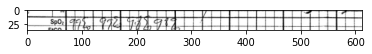

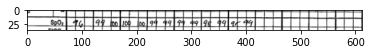

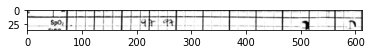

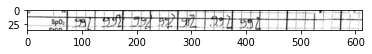

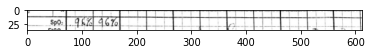

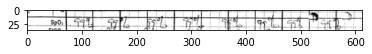

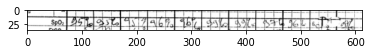

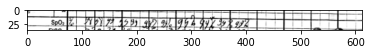

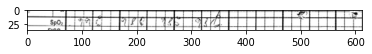

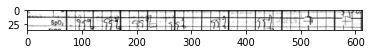

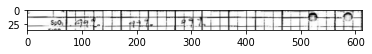

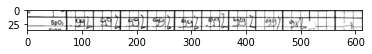

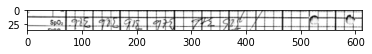

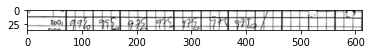

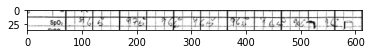

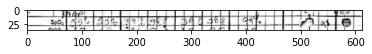

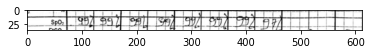

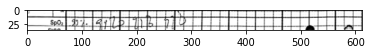

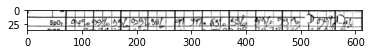

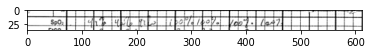

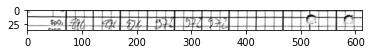

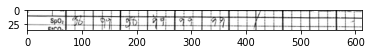

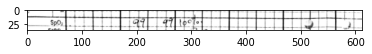

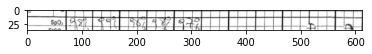

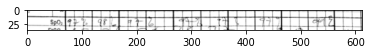

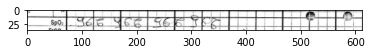

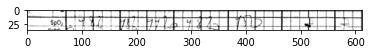

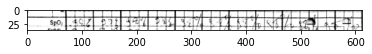

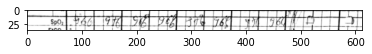

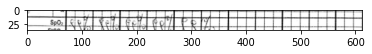

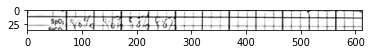

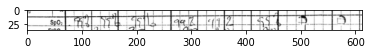

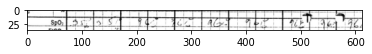

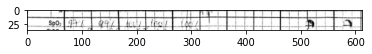

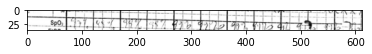

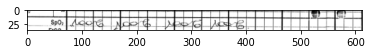

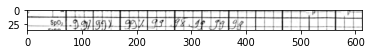

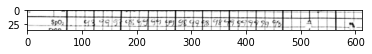

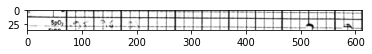

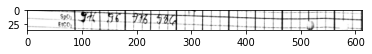

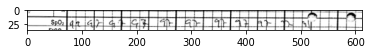

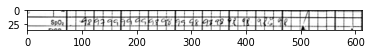

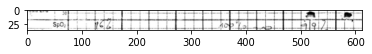

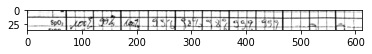

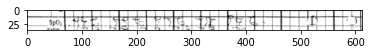

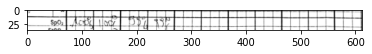

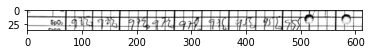

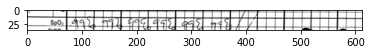

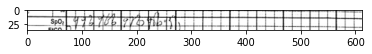

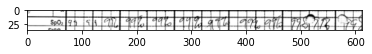

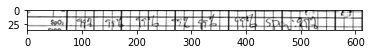

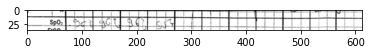

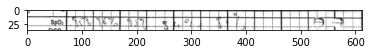

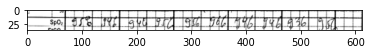

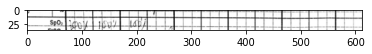

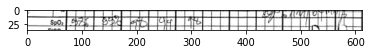

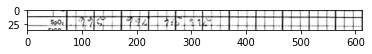

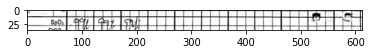

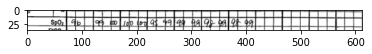

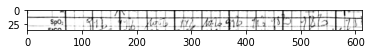

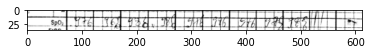

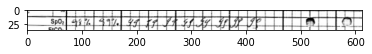

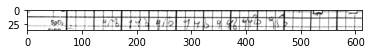

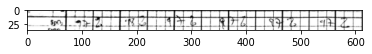

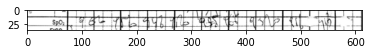

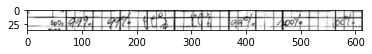

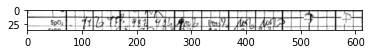

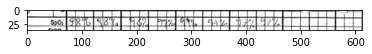

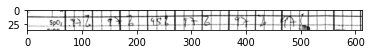

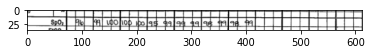

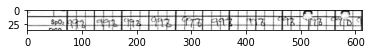

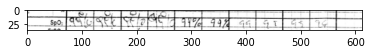

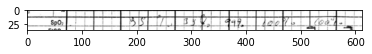

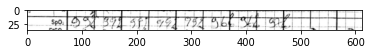

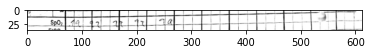

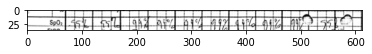

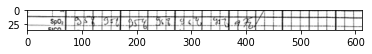

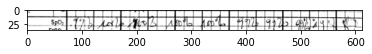

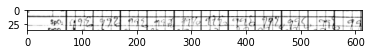

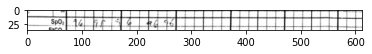

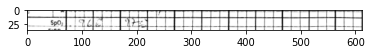

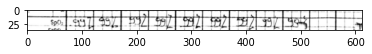

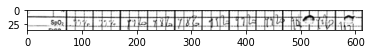

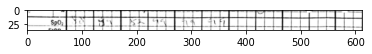

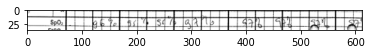

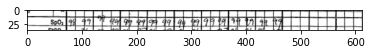

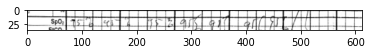

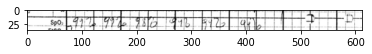

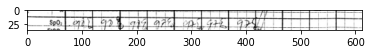

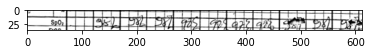

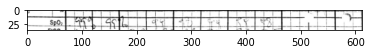

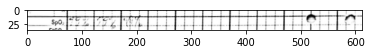

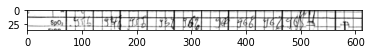

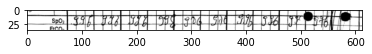

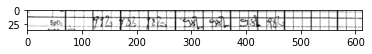

In [56]:
files = ["../Rachel/"+ x for x in os.listdir("../Rachel") if "jpg" in x]

for i in files:
    crop = cropRow(i)
    filename = i.split("/")[2]
    filepath = f"../triple_crops/{filename}"
    cv2.imwrite(filepath,crop)

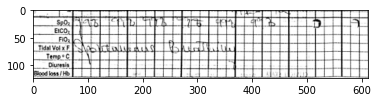

In [20]:
cropQI('011.jpg')

In [21]:
cv2.imwrite('test.jpg',crop)

True

### Manual file list

In [22]:
files = ['011.jpg',
 '3582.jpg',
 '06.jpg',
 '2392.jpg',
 '029.jpg',
 '067.jpg',
 '17FullTestI-1DrChristian9Intraoperative.jpg',
 '3572.jpg',
 '2422.jpg',
 '2612.jpg',
 '3262.jpg',
 '2462.jpg',
 '080.jpg',
 '189.jpg',
 '34022.jpg',
 '028.jpg',
 '2712.jpg',
 '2872.jpg',
 '2032.jpg',
 '118.jpg',
 '009.jpg',
 '112.jpg',
 '088.jpg',
 '2242.jpg',
 '075.jpg',
 '2972.jpg',
 '087.jpg',
 '2982.jpg',
 '3672.jpg',
 '2292.jpg',
 '2812.jpg',
 '3392.jpg',
 '2902.jpg',
 '144.jpg',
 '3562.jpg',
 '181.jpg',
 '019.jpg',
 '130.jpg',
 '3332.jpg',
 '3072.jpg',
 '010.jpg',
 '2102.jpg',
 '2042.jpg',
 '3142.jpg',
 '131.jpg',
 '2182.jpg',
 '14FullTestI-1DrChristian6Intraoperative.jpg',
 '061.jpg',
 '3712.jpg',
 '2992.jpg',
 '013.jpg',
 '4FullTestI.jpg',
 '062.jpg',
 '053.jpg',
 '2192.jpg',
 '116.jpg',
 '100.jpg',
 '2012.jpg',
 '014.jpg',
 '2282.jpg',
 '105.jpg',
 '167.jpg',
 '124.jpg',
 '045.jpg',
 '180.jpg',
 '024.jpg',
 '2562.jpg',
 '064.jpg',
 '005.jpg',
 '038.jpg',
 '2942.jpg',
 '15FullTestI-1DrChristian7Intraoperative.jpg',
 '073.jpg',
 '065.jpg',
 '168.jpg',
 '2492.jpg',
 '2482.jpg',
 '2662.jpg',
 '114.jpg',
 '136.jpg',
 '2082.jpg',
 '026(1).jpg',
 '054.jpg',
 '035.jpg',
 '2452.jpg',
 '2682.jpg',
 '3402.jpg',
 '3552.jpg',
 '036.jpg',
 '185.jpg',
 '022.jpg',
 '2402.jpg',
 '3222.jpg',
 '190.jpg',
 '081.jpg',
 '3432.jpg',
 '042.jpg',
 '056.jpg',
 '109.jpg',
 '188.jpg',
 '2792.jpg',
 '139.jpg',
 '034.jpg',
 '197.jpg',
 '119.jpg',
 '2252.jpg',
 '2472.jpg',
 '049.jpg',
 '043.jpg',
 '3382.jpg',
 '2262.jpg',
 '3422.jpg',
 '2502.jpg',
 '003.jpg',
 '046.jpg',
 '335_2.jpg',
 '3342.jpg',
 '2752.jpg',
 '2782.jpg',
 '19FullTestI-2DrChristian1Intraoperative.jpg',
 '2932.jpg',
 '055.jpg',
 '2092.jpg',
 '121.jpg',
 '137.jpg',
 '21FullTestI-2DrChristian3Intraoperative.jpg',
 '158.jpg',
 '015.jpg',
 '2112.jpg',
 '2412.jpg',
 '3202.jpg',
 '2882.jpg',
 '2302.jpg',
 '3442.jpg',
 '3482.jpg',
 '021.jpg',
 '141.jpg',
 '037.jpg',
 '2272.jpg',
 '3192.jpg',
 '142.jpg',
 '3462.jpg',
 '13FullTestI-1DrChristian5Intraoperative.jpg',
 '063.jpg',
 '091.jpg',
 '237.jpg',
 '173.jpg',
 '31FullTestI-3DrChristian3Intraoperative.jpg',
 '143.jpg',
 '2512.jpg',
 '3522.jpg',
 '11FullTestI-1DrChristian3Intraoperative.jpg',
 '004.jpg',
 '111.jpg',
 '184.jpg',
 '052.jpg',
 '032.jpg',
 '002.jpg',
 '3452.jpg',
 '2962.jpg',
 '0971.jpg',
 '2922.jpg',
 '117.jpg',
 '016.jpg',
 '2432.jpg',
 '025.jpg',
 '074.jpg',
 '132.jpg',
 '099.jpg',
 '120.jpg',
 '115.jpg',
 '126.jpg',
 '3002.jpg',
 '3742.jpg',
 '098.jpg',
 '018.jpg',
 '176.jpg',
 '057.jpg',
 '2022.jpg',
 '177.jpg',
 '191.jpg',
 '135.jpg',
 '026.jpg',
 '198.jpg',
 '101.jpg',
 '023.jpg',
 '044.jpg',
 '18FullTestI-1DrChristian10Intraoperative.jpg',
 '3322.jpg',
 '3372.jpg',
 '3532.jpg',
 '2672.jpg',
 '077.jpg',
 '2312.jpg',
 '007.jpg',
 '3272.jpg',
 '102.jpg',
 '001.jpg',
 '2362.jpg',
 '076.jpg',
 '027.jpg',
 '194.jpg',
 '2122.jpg',
 '140.jpg',
 '039.jpg',
 '195.jpg',
 '2152.jpg',
 '012.jpg',
 '2802.jpg',
 '3692.jpg',
 '047.jpg',
 '2072.jpg',
 '22FullTestI-2DrChristian4Intraoperative.jpg',
 '2692.jpg',
 '066.jpg',
 '3542.jpg',
 '072.jpg',
 '2532.jpg',
 '3752.jpg',
 '3152.jpg',
 '3162.jpg',
 '2642.jpg',
 '156.jpg',
 '090.jpg',
 '3920.jpg',
 '3702.jpg',
 '129.jpg',
 '2062.jpg',
 '174.jpg',
 '2142.jpg',
 '3062.jpg',
 '25FullTestI-2DrChristian7Intraoperative.jpg',
 '089.jpg',
 '145.jpg',
 '146.jpg',
 '147.jpg',
 '148.jpg',
 '149.jpg',
 '151.jpg',
 '155.jpg',
 '159.jpg',
 '161.jpg',
 '164.jpg',
 '165.jpg',
 '166.jpg',
 '169.jpg',
 '171.jpg',
 '172.jpg',
 '178.jpg',
 '179.jpg',
 '186.jpg',
 '3921.JPG',
 '170.jpg']

In [23]:
len(files)

253

In [11]:
cv2.imwrite("test.jpg",crop)

True